<a href="https://colab.research.google.com/github/karl-gardner/cell_classification/blob/main/ENetV2_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 Imports and Drive Mount

In [1]:
%cd /content
!git clone https://github.com/karl-gardner/cell_classification  # clone repo
# !pip install --upgrade tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import cv2
import os
import shutil
import csv
from google.colab import files

%cd /content/cell_classification
import funcs

clear_output()
print(f"Setup complete. Using torch {tf.__version__}")

Setup complete. Using torch 2.11.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.2 Choose Dataset

In [3]:
datasets = ["catsvsdogs", "PC3vsDU145", "PC3vsLnCAP", "SKOV3nvsd"]
class_names = [["dogs", "cats"], ["DU145", "PC3"], ["LnCAP", "PC3"], ["drSKOV3", "nSKOV3"]]
dataset = 3

# 1.3 Filter out Corrupted Images

In [4]:
# # Filter out corrupted .png or .jpg images
# %cd /content/drive/MyDrive/cell_classification/data_files

# class_1, class_2 = funcs.filter(dataset)
# print("# of Class 1 deleted: ", class_1)
# print("# of Class 2 deleted: ", class_2)

#2.1 Load Dataset into tf.Dataset

In [5]:
image_size = (224,224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"/content/drive/MyDrive/cell_classification/data_files/{datasets[dataset]}/split_ds/training",
    seed=1337,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"/content/drive/MyDrive/cell_classification/data_files/{datasets[dataset]}/split_ds/validation",
    seed=1337,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"/content/drive/MyDrive/cell_classification/data_files/{datasets[dataset]}/split_ds/testing",
    seed=1337,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size
)

Found 3491 files belonging to 2 classes.
Found 437 files belonging to 2 classes.
Found 437 files belonging to 2 classes.


# 2.2 Print Dataset Summary Before Augmenation

In [6]:
train_y_true = []
for x,y in train_ds:
  train_y_true.append(y)
train_y_true = tf.concat(train_y_true,axis=0)


val_y_true = []
for x,y in val_ds:
  val_y_true.append(y)
val_y_true = tf.concat(val_y_true,axis=0)

test_y_true = []
for x,y in test_ds:
  test_y_true.append(y)
test_y_true = tf.concat(test_y_true,axis=0)

train_0 = int(tf.reduce_sum(tf.cast(tf.math.equal(train_y_true, 0), tf.int32)))
train_1 = int(tf.reduce_sum(tf.cast(tf.math.equal(train_y_true, 1), tf.int32)))
val_0 = int(tf.reduce_sum(tf.cast(tf.equal(val_y_true, 0), tf.int32)))
val_1 = int(tf.reduce_sum(tf.cast(tf.math.equal(val_y_true, 1), tf.int32)))
test_0 = int(tf.reduce_sum(tf.cast(tf.equal(test_y_true, 0), tf.int32)))
test_1 = int(tf.reduce_sum(tf.cast(tf.math.equal(test_y_true, 1), tf.int32)))
train_comb = train_0 + train_1
val_comb = val_0 + val_1
test_comb = test_0 + test_1

print("Labeled Classes and Images Before Augmentations")
print(f"# of Class {class_names[dataset][0]} combined: {train_0 + val_0 + test_0}")
print(f"# of Class {class_names[dataset][1]} combined: {train_1 + val_1 + test_1}")
print(f"# of total images combined: {train_0 + val_0 + test_0 + train_1 + val_1 + test_1}\n")

print(f"# of Class {class_names[dataset][0]} in training set: ",train_0)
print(f"# of PC-3 Class {class_names[dataset][1]} in training set: ",train_1)
print(f"# training set combined: {train_comb}\n")

print(f"# of Class {class_names[dataset][0]} in val set: {val_0}")
print(f"# of Class {class_names[dataset][1]} in val set: {val_1}")
print(f"# validation set combined: {val_comb}\n")

print(f"# of Class {class_names[dataset][0]} in test set: {test_0}")
print(f"# of Class {class_names[dataset][1]} in test set: {test_1}")
print(f"# test set combined: {test_comb}")

Labeled Classes and Images Before Augmentations
# of Class drSKOV3 combined: 2130
# of Class nSKOV3 combined: 2235
# of total images combined: 4365

# of Class drSKOV3 in training set:  1723
# of PC-3 Class nSKOV3 in training set:  1768
# training set combined: 3491

# of Class drSKOV3 in val set: 218
# of Class nSKOV3 in val set: 219
# validation set combined: 437

# of Class drSKOV3 in test set: 189
# of Class nSKOV3 in test set: 248
# test set combined: 437


#2.3 Augmentation that Didn't Work

In [7]:
# # I don't know why this wouldn't work as a custom layer! I tested this sequential as a layer after the input layer to 
# # the model for the catsvsdogs dataset.  Even with the simple catsvsdogs dataset it kept giving terrible validation
# # accuracy. All of this seems perfectly legal in tensorflow for a custom layer so if anyone figures out why this doesn't 
# # work please let me know.

# # from website: https://towardsdatascience.com/writing-a-custom-data-augmentation-layer-in-keras-2b53e048a98

# class RandomColorDistortion(tf.keras.layers.Layer):
#   def __init__(self, contrast_range=[0.5, 1.5], 
#                 brightness_delta=[-0.2, 0.2], **kwargs):
#       super(RandomColorDistortion, self).__init__(**kwargs)
#       self.contrast_range = contrast_range
#       self.brightness_delta = brightness_delta

#   def call(self, images, training=None):
#           if not training:
#               return images
          
#           contrast = random.uniform(self.contrast_range[0], self.contrast_range[1])
#           brightness = random.uniform(self.brightness_delta[0], self.brightness_delta[1])

#           images = tf.image.adjust_contrast(images, contrast)
#           images = tf.image.adjust_brightness(images, brightness)
#           images = tf.clip_by_value(images, 0, 1)
#           return images

# augment_and_normalize = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
#   RandomColorDistortion(contrast_range=[0.5,1.5], brightness_delta=[-0.15, 0.15]),                       
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomRotation(0.1),
# ], name="augment_and_normalize")

# # Also, I tried this sequential layer with the new tensorflow layer RandomBrightness that came out in version 2.9.0. This augment_and_normalize layer
# # worked perfectly with the cats_vs_dogs dataset but did not work at all with the PC3vsDU145 dataset. The training set couldn't even get past 60%
# # accuracy so there had to be a bug or something wrong with tensorlow. I believe this augment_and_normalize layer is correct with first a random 
# # brightness, then contrast, flip, and rotation giving healthy dataset augmentations! Please let me know if anyone figures out what is wrong with this.

# augment_and_normalize = tf.keras.Sequential([
#   tf.keras.layers.RandomBrightness(0.15),
#   tf.keras.layers.RandomContrast((0.5,0.15)), 
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomRotation(0.1),
#   tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
# ], name="augment_and_normalize")

#2.4 Augment Dataset

In [8]:
def map_func(images, labels):
  images = tf.image.random_brightness(images, 0.15)
  images = tf.image.random_contrast(images, 0.5, 1.5)
  images = tf.image.random_flip_left_right(images)
  images = tf.clip_by_value(images, 0, 255)
  return images,labels

In [9]:
train_aug = train_ds.map(lambda images,labels: map_func(images,labels))
train_ds = train_ds.concatenate(train_aug).unbatch().batch(32).shuffle(4000)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# 3.1 Download Example Images

In [10]:
# def save_images(num_batches=1):
#   shutil.rmtree("/example_images", ignore_errors=True)
#   os.mkdir("/example_images")
#   os.mkdir("/example_images/class_1")
#   os.mkdir("/example_images/class_2")
#   for j, (images, labels) in enumerate(train_ds.take(num_batches)):
#     print("images shape: ",images.shape)
#     for i in range(images.shape[0]):
#       cv2.imwrite(f"/example_images/class_{str(int(labels[i]+1))}/example_{i*(j+1)}.png", images[i].numpy())

# save_images(num_batches=3)
# !rm -r /example_images.zip
# !zip -r /example_images.zip /example_images
# clear_output()
# files.download("/example_images.zip")

# 3.2 Display Example Images

images shape:  (32, 224, 224, 3)


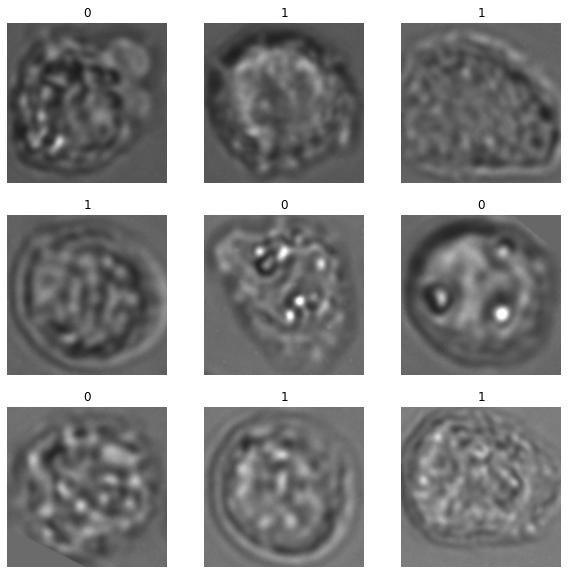

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print("images shape: ",images.shape)
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

#4.1 Generate EfficientNet Model For Binary Classification

24274472/24274472 [==============================] - 2s 0us/step


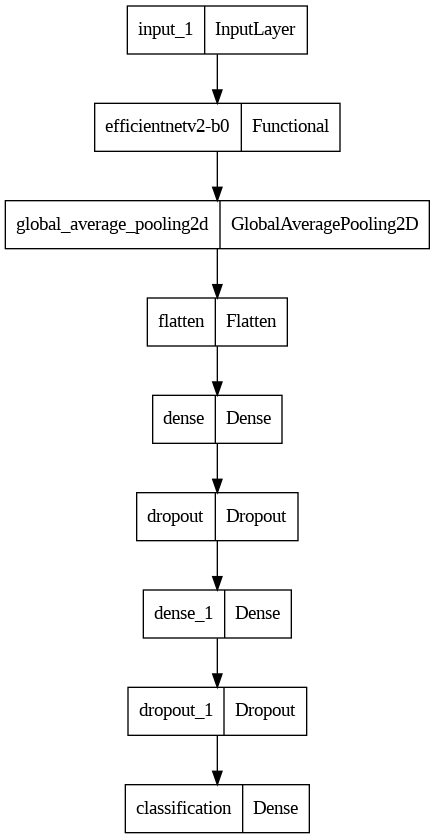

In [12]:
def make_model(input_shape, num_classes):
    input = tf.keras.Input(shape=input_shape)
    # Entry block
    feature_extractor = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')(input)
    x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="classification")(x)
    return tf.keras.Model(input, output)

model = make_model(input_shape=image_size + (3,), num_classes=2)

tf.keras.utils.plot_model(model)

# 4.2 Compile and Train Model

In [13]:
%cd /content/cell_classification
epochs = 150

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# history = model.fit(x=train_ds, epochs=epochs, validation_data=val_ds,
#      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="weights.{epoch:02d}.ckpt", monitor='val_accuracy',
#      verbose=0, save_best_only=True,save_weights_only=True, mode='auto', save_freq='epoch',options=None)])

/content/cell_classification


# 5.1 Display training results for all datasets

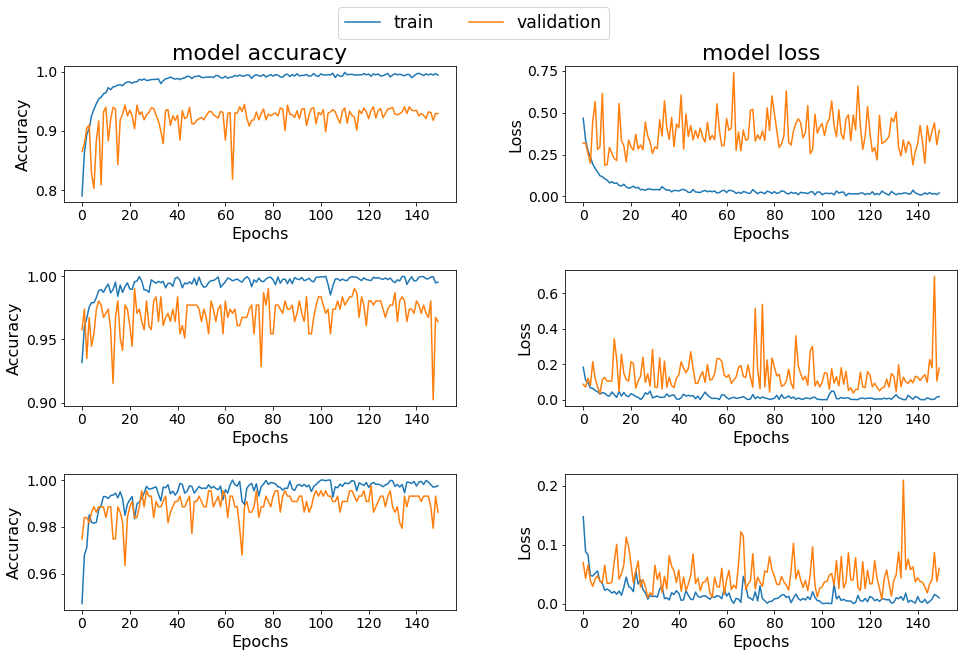

In [14]:
epoch_nums=[29,69,23,122]

# shutil.copy(f"/content/cell_classification/weights.{epoch_nums[dataset]}.ckpt.data-00000-of-00001",
#             f"/content/drive/MyDrive/ctc_classification/data_files/{datasets[dataset]}/ENetweights.{epoch_nums[dataset]}.ckpt.data-00000-of-00001")
# shutil.copy(f"/content/cell_classification/weights.{epoch_nums[dataset]}.ckpt.index",
#             f"/content/drive/MyDrive/ctc_classification/data_files/{datasets[dataset]}/ENetweights.{epoch_nums[dataset]}.ckpt.index")

# with open(f"/content/drive/MyDrive/cell_classification/data_files/{datasets[dataset]}/ENet_train_results.csv", 'w', newline='') as csvfile:
#   spamwriter = csv.writer(csvfile)
#   spamwriter.writerow(['row 1: train loss, row 2: train accuracy, row 3: validation loss, row 4: validation accuracy'])
#   spamwriter.writerow(np.array(history.history["loss"]))
#   spamwriter.writerow(np.array(history.history["accuracy"]))
#   spamwriter.writerow(np.array(history.history["val_loss"]))
#   spamwriter.writerow(np.array(history.history["val_accuracy"]))


fig, axs = plt.subplots(3,2,figsize=(16,10))
axs = axs.flatten()
bottom = [None,-50,-5]
for i in range(len(datasets)-1):
  train_results = []
  with open(f"/content/drive/MyDrive/cell_classification/data_files/{datasets[i+1]}/ENet_train_results.csv", newline='') as csvfile:
    spamreader = csv.reader(csvfile,)
    next(spamreader)
    for row in spamreader:
      train_results.append(row)
    train_results = np.array(train_results).astype(float)

  axs[i*2].plot(train_results[1, :])
  axs[i*2].plot(train_results[3, :])  
  axs[i*2].set_xlabel('Epochs', fontsize=16)
  axs[i*2].set_ylabel('Accuracy', fontsize=16)
  axs[i*2].tick_params(labelsize=14)

  axs[i*2+1].plot(train_results[0, :])
  axs[i*2+1].plot(train_results[2, :])
  axs[i*2+1].set_xlabel('Epochs', fontsize=16)
  axs[i*2+1].set_ylabel('Loss', fontsize=16)
  axs[i*2+1].tick_params(labelsize=14)

  if i == 0:
    axs[i*2].legend(['train', 'validation'], loc=(0.7,1.2), ncol=2, fontsize="xx-large")
    axs[i*2].set_title('model accuracy', fontsize=22)
    axs[i*2+1].set_title('model loss', fontsize=22)


fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.28)
plt.show()
# fig.savefig('/content/ENet_train_results.tif', dpi= 500, bbox_inches="tight")
# files.download('/content/ENet_train_results.tif')

# 5.2 Load Tensorflow Weights and Evaluate

In [15]:
model.load_weights(f"/content/drive/MyDrive/cell_classification/data_files/{datasets[dataset]}/ENetweights.{epoch_nums[dataset]}.ckpt")
model.evaluate(test_ds)

14/14 [==============================] - 11s 104ms/step - loss: 0.0702 - accuracy: 0.9931


[0.07016578316688538, 0.9931350350379944]

# 5.3 Generate Confusion Matrix

14/14 [==============================] - 2s 49ms/step
accuracy:  0.9931350114416476


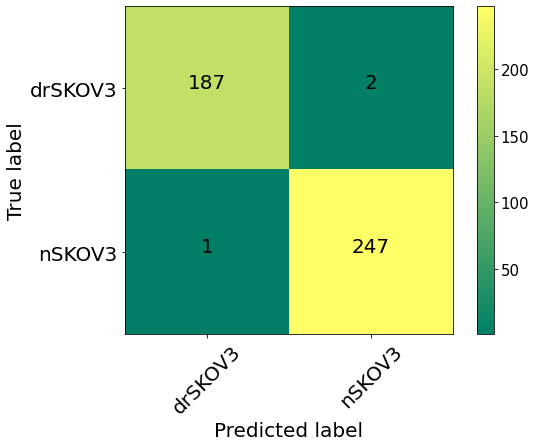

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
fname = f"/{datasets[dataset]}_cm.tif"
test_images = []
test_y_true = []
for x,y in test_ds:
  test_images.append(x)
  test_y_true.append(y)
test_images = tf.concat(test_images,axis=0)
test_y_true = tf.concat(test_y_true,axis=0)

y_pred = model.predict(test_images)
y_pred = tf.cast(tf.reshape(tf.math.round(y_pred),tf.shape(y_pred)[0]),tf.int32)

confusion_tensor = tf.math.confusion_matrix(test_y_true,y_pred)
acc = np.mean(y_pred == test_y_true)
print("accuracy: ",acc)

funcs.save_confusion_matrix(confusion_tensor.numpy(), class_names[dataset], fname, normalize= False)
files.download(fname)